In [1]:
# Initialize database connection
from server_utils.data_management import DataManager

dm = DataManager()

localhost postgres tutorial


In [2]:
# load tickers to include in portfolio
dm.query_df('SELECT * FROM used_tickers')

,ticker,company_name,currency,category
0,AMD,"Advanced Micro Devices, Inc.",USD,stock
1,GME,GameStop Corp.,USD,stock
2,VOLV-B.ST,Volvo B,SEK,stock
3,INVE-B.ST,Investor AB (publ),SEK,stock
4,NAS.OL,Norwegian Air Shuttle,NOK,stock
5,NVDA,Nvidia Corporation,USD,stock
6,AAPL,Apple,USD,stock
7,GOOGL,Google,USD,stock


In [3]:
dm.query_df('SELECT * FROM daily_returns ORDER BY date DESC LIMIT 10')

,date,ticker,arithmetic_return,logarithmic_return
0,2021-08-03,INVE-B.ST,0.004688,0.004677
1,2021-08-03,NVDA,0.003291,0.003286
2,2021-08-03,GOOGL,0.005751,0.005734
3,2021-08-03,AAPL,0.012644,0.012565
4,2021-08-03,VOLV-B.ST,-0.001726,-0.001728
5,2021-08-03,NAS.OL,0.032926,0.032395
6,2021-08-03,AMD,0.036178,0.035539
7,2021-08-03,GME,-0.031081,-0.031575
8,2021-08-02,VOLV-B.ST,0.000000,0.000000
9,2021-08-02,GOOGL,0.000950,0.000950


In [4]:
# Get daily returns for three stocks for the past three years
import numpy as np
import pandas as pd
sql = """
SELECT s1.date, s1.arithmetic_return AS NVDA, s2.arithmetic_return AS AMD, s3.arithmetic_return AS GOOGL 
FROM daily_returns AS s1
INNER JOIN daily_returns AS s2 ON s1.ticker='NVDA' AND s2.ticker='AMD' and s2.date=s1.date
INNER JOIN daily_returns AS s3 ON s3.ticker='GOOGL' and s3.date=s2.date
ORDER BY DATE DESC LIMIT 365*5;
"""

stock_data = dm.query_df(sql)
stock_data = stock_data.iloc[::-1]
stock_data.tail()


,date,nvda,amd,googl
4,2021-07-28,0.015358,0.075799,0.031797
3,2021-07-29,0.008153,0.051261,-0.002326
2,2021-07-30,-0.008290,0.031472,-0.007741
1,2021-08-02,0.012872,0.022978,0.000950
0,2021-08-03,0.003291,0.036178,0.005751


In [5]:

portfolio_weights = np.transpose([1/3, 1/3, 1/3])
stock_returns = stock_data[['nvda', 'amd', 'googl']]
portfolio_returns = np.matmul(stock_returns, portfolio_weights)
# add returns to df
stock_data['portfolio'] = portfolio_returns
# add the dates back
stock_data.tail()

,date,nvda,amd,googl,portfolio
4,2021-07-28,0.015358,0.075799,0.031797,0.040985
3,2021-07-29,0.008153,0.051261,-0.002326,0.019029
2,2021-07-30,-0.008290,0.031472,-0.007741,0.005147
1,2021-08-02,0.012872,0.022978,0.000950,0.012267
0,2021-08-03,0.003291,0.036178,0.005751,0.015073


In [6]:
# we can approximate a loss that with 99% will not exceed by taking the 99th percentile of our losses
from finance_utils import VaR

value_at_risk = VaR.historical_simulation_relative_VaR(portfolio_returns, 365, prctile=95)
# extract the realized losses (-returns) for the same period
losses = -portfolio_returns[-value_at_risk.shape[0]:]


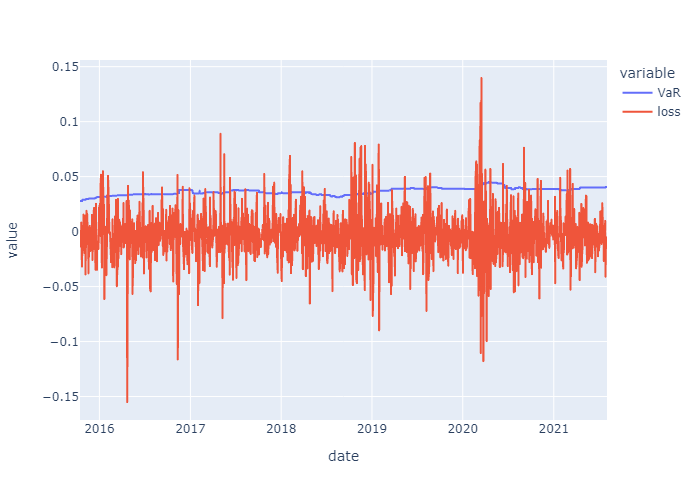

In [7]:
import plotly.express as px
# visualize the losses and the estimates
plot_df = pd.DataFrame()
plot_df['date']=stock_data['date'][-value_at_risk.shape[0]:]
plot_df['loss']=losses
plot_df['VaR']=value_at_risk

fig = px.line(plot_df, x='date', y=['VaR', 'loss'])
fig.show('svg')

In [8]:
# We want to verify that our VaR estimates are accurate
np.sum(losses>value_at_risk)/losses.shape[0]
# We can see that our loss only exceeds the VaR estimate ~4% of the times

0.04657534246575343